# Assignment 2

In this document I implement custom edge detectors and compare them between eachother

code with images available at https://github.com/usaginoki/CSCI-585-CV-assignments

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
# auxiliary functions

def non_maximum_suppression(img, angle):
    # get image shape
    height, width = img.shape
    
    # define new image
    new_img = np.zeros((height, width))
    
    # loop through image
    for i in range(1, height-1):
        for j in range(1, width-1):
            # get angle
            ang = angle[i, j]
            
            # check angle
            if (ang < 0):
                ang += np.pi
            
            # check angle
            if (0 <= ang < 1/4*np.pi) or (7/4*np.pi <= ang < 2*np.pi):
                q = img[i, j+1]
                r = img[i, j-1]
            elif (1/4*np.pi <= ang < 3/4*np.pi):
                q = img[i+1, j-1]
                r = img[i-1, j+1]
            elif (3/4*np.pi <= ang < 5/4*np.pi):
                q = img[i+1, j]
                r = img[i-1, j]
            else:
                q = img[i-1, j-1]
                r = img[i+1, j+1]
                
            # check if pixel is local maximum
            if (img[i, j] >= q) and (img[i, j] >= r):
                new_img[i, j] = img[i, j]
            else:
                new_img[i, j] = 0
                
    return new_img


def get_neihbors(i, j, height, width):
    neighbors = []
    borders_x = [i]
    borders_y = [j]
    if i>0:
        borders_x.append(i-1)
    if i<height-1:
        borders_x.append(i+1)
    if j>0:
        borders_y.append(j-1)
    if j<width-1:
        borders_y.append(j+1)
    for x in borders_x:
        for y in borders_y:
            if (x, y) == (i, j):
                continue
            neighbors.append((x, y))
    return neighbors


def hysterisis_threshold(img, low, high):
    # get image shape
    height, width = img.shape
    
    # define new image
    edges = np.zeros((height, width))
    
    # loop through image
    for i in range(1, height-1):
        for j in range(1, width-1):
            # get pixel value
            pixel = img[i, j]
            
            # check if pixel is above high threshold
            if pixel > high:
                edges[i, j] = 1
            # check if pixel is below low threshold
            elif pixel < low:
                edges[i, j] = 0
            # check if pixel is between thresholds
            else:
                neighbors = get_neihbors(i, j, height, width)
                for neighbor in neighbors:
                    x, y = neighbor
                    if img[x, y] > high:
                        edges[i, j] = 1
                        break
            
    return edges

def normal_threshold(img, threshold):
    # get image shape
    height, width = img.shape
    
    # define new image
    new_img = np.zeros((height, width))
    
    # loop through image
    for i in range(1, height-1):
        for j in range(1, width-1):
            # get pixel value
            pixel = img[i, j]
            
            # check if pixel is above threshold
            if pixel > threshold:
                new_img[i, j] = 1
            else:
                new_img[i, j] = 0

    return new_img

def generate_gaussian_kernel(size, sigma):
    # generate kernel
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-size//2)**2 + (y-size//2)**2)/(2*sigma**2)), (size, size))
    
    return kernel

In [3]:
# custom classes

class MyFilter:
    def __init__(self, filter_x, filter_y):
        self.x = filter_x
        self.y = filter_y

class Filtering:
    def __init__(self, filter, padding=True):
        self.filter = filter
        self.padding = padding

    def process(self, img):
        # get image shape
        height, width = img.shape

        # check if padding is needed
        if self.padding:
            # create new image with padding
            new_img = np.zeros((height+2, width+2))
            new_img[1:height+1, 1:width+1] = img
            # update image shape
            height += 2
            width += 2
        
        else:
            new_img = img

        # define new image
        magnitudes = np.zeros((height, width))
        angles = np.zeros((height, width))

        # loop through image
        for i in range(1, height-1):
            for j in range(1, width-1):
                # get 3x3 window
                window = new_img[i-1:i+2, j-1:j+2]
                
                # calculate gradient
                Gx = np.sum(self.filter.x * window)
                Gy = np.sum(self.filter.y * window)
                
                # calculate angle
                angles[i, j] = np.arctan2(Gy, Gx)
                
                # calculate magnitude
                G = np.sqrt(Gx**2 + Gy**2)
                
                # update new image
                magnitudes[i, j] = G

        return magnitudes, angles
    
class Thresholding:
    def __init__(self, algo, low_threshold, high_threshold = None):
        self.algo = algo
        self.low_threshold = low_threshold
        self.high_threshold = high_threshold

    def process(self, img):
        if self.algo == 'hysteresis':
            if self.high_threshold is None:
                raise ValueError('High threshold must be provided for hysteresis thresholding')
            return hysterisis_threshold(img, self.low_threshold, self.high_threshold)
        
        elif self.algo == 'normal':
            return normal_threshold(img, self.low_threshold)
        
class MySmoothie:
    def __init__(self, kernel_size=5, name='gaussian', sigma=1, padding=True):
        self.kernel_size = kernel_size
        if name == 'gaussian':
            self.kernel = generate_gaussian_kernel(kernel_size, sigma)
        elif name == 'box':
            self.kernel = np.ones((kernel_size, kernel_size)) / kernel_size**2

        self.padding = padding

    def process(self, img):
        # get image shape
        height, width = img.shape

        # check if padding is needed
        if self.padding:
            # create new image with padding
            # account for kernel size
            new_img = np.zeros((height+self.kernel_size-1, width+self.kernel_size-1))
            new_img[self.kernel_size//2:height+self.kernel_size//2, self.kernel_size//2:width+self.kernel_size//2] = img
            # update image shape
            height += self.kernel_size-1
            width += self.kernel_size-1
        
        else:
            new_img = img

        # define new image
        smoothed_img = np.zeros((height, width))

        # loop through image
        for i in range(self.kernel_size//2, height-self.kernel_size//2):
            for j in range(self.kernel_size//2, width-self.kernel_size//2):
                # get kernel
                window = new_img[i-self.kernel_size//2:i+self.kernel_size//2+1, j-self.kernel_size//2:j+self.kernel_size//2+1]
                
                # apply kernel
                smoothed_img[i, j] = np.sum(self.kernel * window)

        return smoothed_img

In [4]:
# initialize filters and filterings

sobel_filter = MyFilter(np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]), np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]))
preweitt_filter = MyFilter(np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]), np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]]))
schar_filter = MyFilter(np.array([[3, 0, -3], [10, 0, -10], [3, 0, -3]]), np.array([[3, 10, 3], [0, 0, 0], [-3, -10, -3]]))

soblel_filtering = Filtering(sobel_filter, True)
preweitt_filtering = Filtering(preweitt_filter, True)
schar_filtering = Filtering(schar_filter, True)

In [5]:
class CustomEdgeDetector:
    def __init__(self, filtering, smoothing=None, threshholding=None):
        if smoothing is None:
            self.smoothing = MySmoothie()
        else:
            self.smoothing = smoothing

        self.filtering = filtering

        if threshholding is None:
            threshholding = Thresholding('normal', 100)
        else:
            self.threshholding = threshholding
    
    def process(self, img):
        smoothed = self.smoothing.process(img)
        magnitudes, angles = self.filtering.process(smoothed)
        filtered = non_maximum_suppression(magnitudes, angles)
        return self.threshholding.process(filtered)

In [6]:
low = 50
high = 100

In [7]:
# configuration 1: sobel filter, gaussian smoothing, hysterisis thresholding
detector1 = CustomEdgeDetector(soblel_filtering, MySmoothie(), Thresholding('hysteresis', low, high))

# configuration 2.1: preweitt filter, gaussian smoothing, hysterisis thresholding
detector2_1 = CustomEdgeDetector(preweitt_filtering, MySmoothie(), Thresholding('hysteresis', low, high))

# configuration 2.2: schar filter, gaussian smoothing, hysterisis thresholding
detector2_2 = CustomEdgeDetector(schar_filtering, MySmoothie(), Thresholding('hysteresis', low, high))

# configuration 3.1: sobel filter, gaussian smoothing, normal thresholding at low
detector3_1 = CustomEdgeDetector(soblel_filtering, MySmoothie(), Thresholding('normal', low))

# configuration 3.2: sobel filter, gaussian smoothing, normal thresholding at (low+high)/2
detector3_2 = CustomEdgeDetector(soblel_filtering, MySmoothie(), Thresholding('normal', (low+high)/2))

# configuration 3.3: sobel filter, gaussian smoothing, normal thresholding at high
detector3_3 = CustomEdgeDetector(soblel_filtering, MySmoothie(), Thresholding('normal', high))

In [8]:
# load image
img = cv2.imread('./Edge Detection.png', cv2.IMREAD_GRAYSCALE)

In [9]:
# find edges using canny edge detector from opencv as a reference
def canny_edge_detector(img, low=50, high=100):
    edges = cv2.Canny(img, low, high)
    return edges

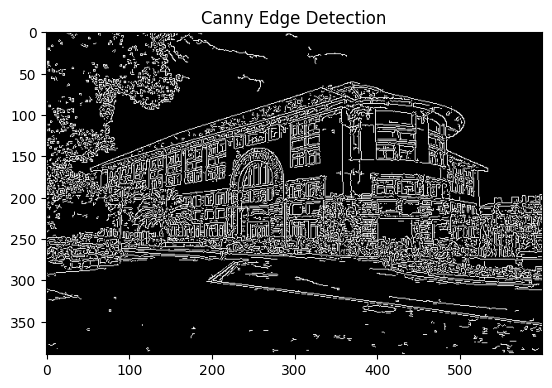

In [10]:
# plot the reference edge detection
edges = canny_edge_detector(img)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.show()

In [11]:
# find edges using custom edge detectors
edges1 = detector1.process(img)
edges2_1 = detector2_1.process(img)
edges2_2 = detector2_2.process(img)
edges3_1 = detector3_1.process(img)
edges3_2 = detector3_2.process(img)
edges3_3 = detector3_3.process(img)

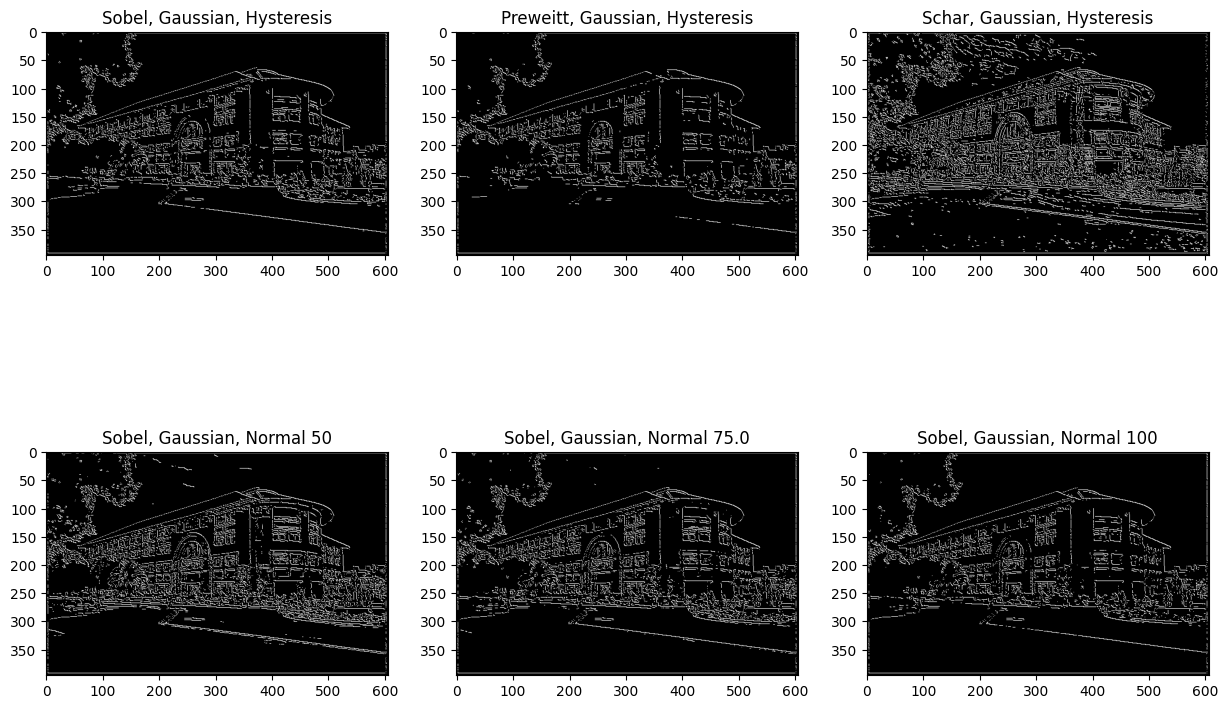

In [12]:
# plot custom edge detection

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(edges1, cmap='gray')
plt.title('Sobel, Gaussian, Hysteresis')


plt.subplot(2, 3, 2)
plt.imshow(edges2_1, cmap='gray')
plt.title('Preweitt, Gaussian, Hysteresis')

plt.subplot(2, 3, 3)
plt.imshow(edges2_2, cmap='gray')
plt.title('Schar, Gaussian, Hysteresis')

plt.subplot(2, 3, 4)
plt.imshow(edges3_1, cmap='gray')
plt.title(f'Sobel, Gaussian, Normal {low}')

plt.subplot(2, 3, 5)
plt.imshow(edges3_2, cmap='gray')
plt.title(f'Sobel, Gaussian, Normal {(low+high)/2}')

plt.subplot(2, 3, 6)
plt.imshow(edges3_3, cmap='gray')
plt.title(f'Sobel, Gaussian, Normal {high}')

plt.show()

In [ ]:
# Discussion Part 2: Sobel supremacy
# In this experiment, we observe that sobel filter outperforms preweitt and schar filters in edge detection.
# This is because sobel filter has a better gradient calculation than the other two filters. 
# In particular, preweitt filter dilutes the gradient calculation by using a uniform kernel, while schar filter uses a kernel that is too sharp.
# As a result, preweitt filter is less sensetive to edges, while schar filter is too sensetive to edges.

# Discussion Part 3: Hysteresis supremacy
# In this experiment, we observe that hysteresis thresholding outperforms normal thresholding in edge detection.
# Hysteresis thresholding with (low, high) = (50, 100) produces results similar to Normal thresholding with threshold = 100,
# but retains more details and edge continuity.
# Normal thresholding with lower thresholds produce more noise.
# Flexibility of hysteresis thresholding allows for better edge detection.